This notebook corresponds to the development of Script chapter 3.4.1. from the main text of the dissertation titled: Nobel Microorganisms Associated with Corrosion by this Author. This notebook is dedicated to the preprocessing and analysis of bacterial data to identify the most influential bacteria associated with corrosion. The aim is to narrow down the list of bacteria from the initial 880 taxa levels to a more manageable number based on specific criteria.

Script to narrow down the most important bacteria following criteria chapter 3.3 main text
### Objectives:
Filtering by Abundance: We aim to identify the most relevant bacteria by filtering out those with a concentration of less than 2%. This ensures that we focus only on bacteria that have a significant presence in the samples.

Influence Analysis: After filtering by abundance, the next step is to sort the remaining bacteria based on their occurrence in each traffic light category. This is done by creating an 'influence' column that counts the frequency of each bacteria in the samples. This helps in understanding which bacteria are consistently present across samples.

Statistical Analysis: A non-parametric test is performed to determine if there are any bacteria that are significantly associated with corrosion in each traffic light category.

### Filtering and sorting

In [1]:
# Import the pandas library for data manipulation
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from statsmodels.formula.api import ols

In [2]:
# Read the excel file coming from notebook Splitdf.ipynb
traffic_1  = pd.read_csv('data/abundance_1.csv', dtype={i: float for i in range(1, 18)})
traffic_2  = pd.read_csv('data/abundance_2.csv', dtype={i: float for i in range(1, 33)})
traffic_3  = pd.read_csv('data/abundance_3.csv', dtype={i: float for i in range(1, 22)})

In [3]:
# Making sure the column GID is taken as an integer type
traffic_1 ["GID"] = traffic_1["GID"].astype("int")
traffic_2 ["GID"] = traffic_2["GID"].astype("int")
traffic_3 ["GID"] = traffic_3["GID"].astype("int")

In [4]:
def filter_values_by_threshold(traffic, threshold_percentage):
    """
    Filter the columns of a DataFrame based on a given threshold percentage.

    Parameters:
    data_excluded (pd.DataFrame): The input DataFrame to be filtered.
    threshold_percentage (float): The threshold percentage used to filter the data.

    Returns:
    pd.DataFrame: A DataFrame containing the filtered values for each sample based on the provided threshold percentage.
    """

    # Create an empty DataFrame with the same columns as the original DataFrame, which only contain the traffic data without the 6 taxa levels
    filtered_abundance = pd.DataFrame(columns=traffic.columns)

    # Loop through each column (sample) in data, excluding the 'GID' column
    for column in traffic.columns[1:]:
        # Calculate the threshold value for the current column based on the percentage
        threshold = traffic[column].sum() * (threshold_percentage / 100)

        # Filter the rows in the current column where the value is greater than or equal to the threshold
        filtered_data = traffic[traffic[column] >= threshold]

        # Append the filtered_data to the filtered_abundance DataFrame
        filtered_abundance = filtered_abundance.append(filtered_data, ignore_index=True)

    # Drop duplicates in the 'GID' column and reset the index
    filtered_abundance = filtered_abundance.drop_duplicates(subset='GID', keep='first').reset_index(drop=True)

    return filtered_abundance

In [5]:
def get_frequency_GID(filtered_abundance):
    """
    Count the occurrences of each GID in the samples and merge the influence counts with the original DataFrame.

    Parameters:
    filtered_abundance (pd.DataFrame): The input DataFrame with filtered data.

    Returns:
    pd.DataFrame: A DataFrame with the added 'Influence' column, sorted by 'Influence' in descending order.
    """

    # Initialize an empty dictionary to store the GID counts
    gid_counts = {}

    # Loop through each column (sample) in filtered_abundance, excluding the 'GID' column
    for column in filtered_abundance.columns[1:]:
        # Count the occurrences of each GID in the current column and update the gid_counts dictionary
        for index, row in filtered_abundance.iterrows():
            if row[column] != 0:
                gid = row['GID']
                gid_counts[gid] = gid_counts.get(gid, 0) + 1

    # Create a DataFrame with the 'GID' and 'Influence' columns from the gid_counts dictionary
    influence_df = pd.DataFrame(list(gid_counts.items()), columns=['GID', 'Influence'])

    # Merge the influence_df DataFrame with the filtered_abundance DataFrame on the 'GID' column
    influencers_genus = filtered_abundance.merge(influence_df, on='GID')

    # Sort the influence_genera DataFrame by the 'Influence' column in descending order
    influencers_genus = influencers_genus.sort_values(by='Influence', ascending=False).reset_index(drop=True)

    return influencers_genus

In [6]:
# Filter values by threshold
threshold_percentage = 2

filtered_abundance_1 = filter_values_by_threshold(traffic_1, threshold_percentage)
filtered_abundance_2 = filter_values_by_threshold(traffic_2, threshold_percentage)
filtered_abundance_3 = filter_values_by_threshold(traffic_3, threshold_percentage)

# Get the frequency of GID
influencers_genus_1 = get_frequency_GID(filtered_abundance_1)
influencers_genus_2 = get_frequency_GID(filtered_abundance_2)
influencers_genus_3 = get_frequency_GID(filtered_abundance_3)

### Statistic Analysis to know if the genera is significatively associated with corrosion
 I need to know if there are Genera/GIDs significant to corrosion in each of the categories of corrosion namely traffic lights TL, because of that I will groupby the TL and analyse between the Genera/GIDs belogning to each TL are differences with respect to all the TL. I want to compare if the gids AKA genus AKA taxa, in TL1 that are also in TL2 and TL3 have significant differences regarding abundance with the TL2 and TL3. My idea with the GIDs present in all the TL that are not significant to corrosion is to remove them, but the keep the GIDs that are significant to each category of corrosion. Going forward to do a machine learnign method that be supervised learning we need to have the GIDs that are present on each category and represent it in relation with corrosion. I am expected to left in TL1 the GIDs that are no associated with corrosion at all, plus the ones that are present in TL2 and TL3 but that due to abundance are relevant to corrosion, because they are markers that there is not problem. Subsequently I will identify the GIDs that are present in TL2 and also check if the abundance of the ones that are also in TL1 and TL2 varies depending on the category of corrosion or TL, keep this GIDs as TL2. Then the GIDs that are only present in TL3 will be all left except the ones that have been already detected to be present in all the TL without relation to corrosion

## Statistical Analysis in Taxa amongst Categories

Objective: To determine the significance of Genera/GIDs across different Traffic Light (TL) categories in relation to corrosion.

Step 3: MANOVA, For each group, perform MANOVA to assess if the abundance values significantly vary across the sites.

Step 4: Post-hoc Analysis: If MANOVA is significant, perform Tukey's HSD test to determine which specific pairs of sites are different.

Step 5: Interpretation. Based on the results, decide which GIDs to retain and which ones to exclude for dimensionality reduction.

For each common GID, document whether there's a significant difference in abundance across TL categories.
GIDs that don't exhibit significant differences might be less informative for corrosion differentiation and could be considered for exclusion in subsequent analyses.

Before I can perform the MANOVA, I need to identify the common GIDs across influencers_genus_1, influencers_genus_2, and influencers_genus_3.

The influencers_genus_1, 2 and 3 come from the filtering of high abundancy percentange and frecuency, so this are the selected gids amongst each category that are most relevant in each, now a single dataframe would be made dfs that apend akk the columns of all the influencers together on a single df named dfs, this is a wide formate df and so later there will be melted and concatenated to be on long format and be plotted on a facegrit sns graph.

In [7]:
# List of dataframes
dfs = [influencers_genus_1, influencers_genus_2, influencers_genus_3]
categories = ["TL1", "TL2", "TL3"]

dfs_T = []

for df, category in zip(dfs, categories):
    # Set "GID" as index and rename the index to "Sites"
    df = df.set_index("GID").rename_axis("Sites")
       
    # Transpose the dataframe
    df_T = df.T
    
    # Drop the last row
    df_T = df_T.drop(df_T.index[-1])
    
    # Add the "Category" column
    df_T["Category"] = category
    
    # Reorder columns to have "Category" as the first column
    cols = ['Category'] + [col for col in df_T.columns if col != 'Category']
    df_T = df_T[cols]
        
    dfs_T.append(df_T)

# Transformed dataframes
influencers_1_T, influencers_2_T, influencers_3_T = dfs_T

The data hier joined as dfs come from the previous arangment and comprise 77 genera from influencers_genus_1, 92 genera from influencers_genus_2 and 85 genera from influencers_genus_3. This are selected genera and could comprise Genus that are on all the three df or in two or only one of them. IN total there are 254 genera coming from 882.

In [8]:
print(influencers_genus_1.shape, influencers_genus_2.shape, influencers_genus_3.shape)

(77, 19) (92, 34) (85, 23)


In [9]:
# Melt each dataframe
melted_dfs = [df.reset_index().melt(id_vars=["index", "Category"], value_name="Abundance", var_name="GID").rename(columns={"index": "Sites"}) for df in dfs_T]

# Concatenate the melted dataframes
long_df = pd.concat(melted_dfs, ignore_index=True)
long_df.shape

(6038, 4)

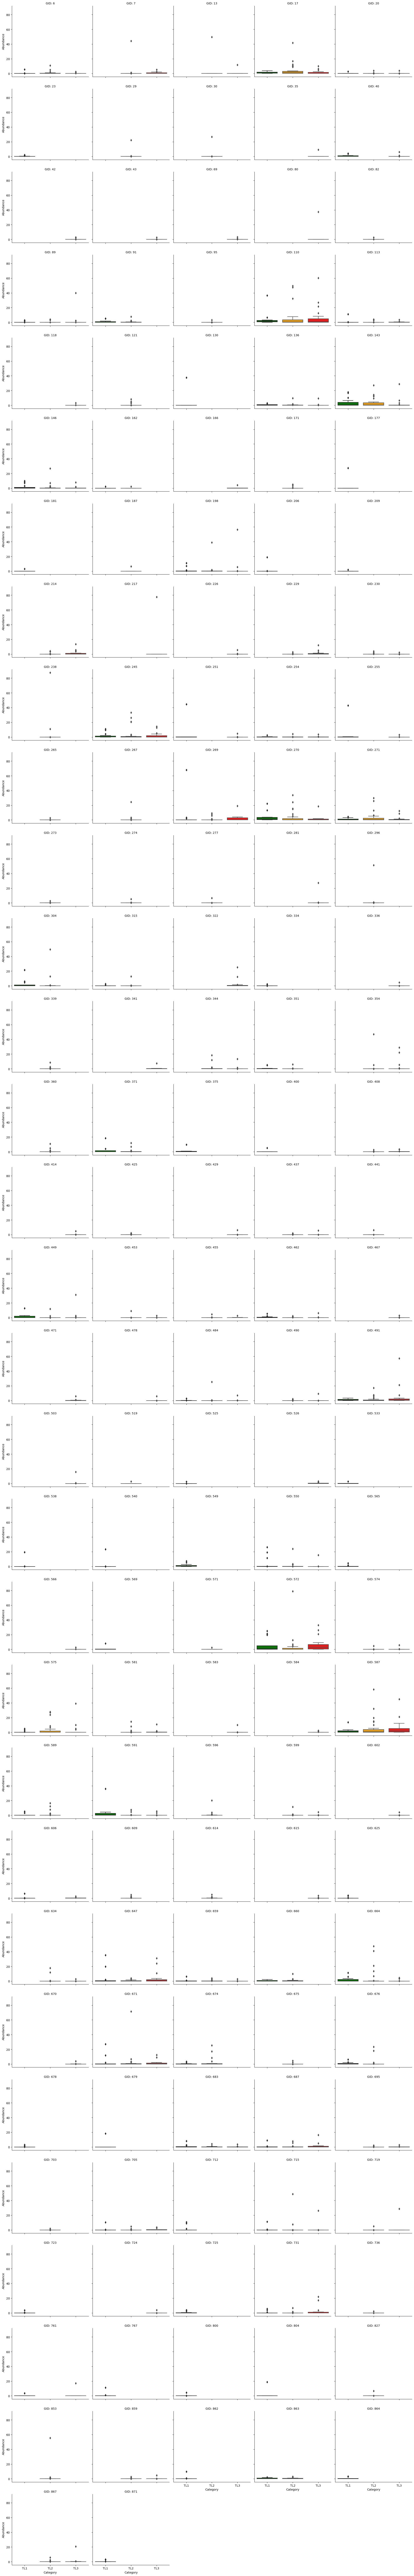

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Categories and colors
categories = [1, 2, 3]
colors = ['green', 'orange', 'red']

# Wrapper function to ignore the 'label' argument
def boxplot_wrapper(x, y, **kwargs):
    sns.boxplot(x=x, y=y, **{k: v for k, v in kwargs.items() if k != 'label'})

# Create a Facet Grid of Boxplots
g = sns.FacetGrid(long_df, col="GID", col_wrap=5, hue="Category", palette=colors, height=4, aspect=1)
g.map(boxplot_wrapper, "Category", "Abundance", order=["TL1", "TL2", "TL3"])
g.set_axis_labels("Category", "Abundance")
g.set_titles("GID: {col_name}")

plt.show()


This plot is actually misleading because corresponds to the influencers, so that means that some genera appear to be only on one of the category but in reality they are not just are ploted because they are on the influencers dfs so they get plotted, but they are not, this should be no taken into account. 
Lets brake down the features we discussing: GID: This represents the unique identifier for each genus. It's the primary feature of interest.
Abundance: This represents the abundance of each GID in different samples. Influence: This is a derived feature that accounts for both the abundance and frequency of the GID. Main objective being: determine which genus (GIDs) (and their abundances) significantly influence the category they belong to. In essence, to identify which GIDs can be used as potential biomarkers or indicators for each category.
MANOVA: determine if the multivariate mean abundances of the common GIDs are different across the categories. This will give an overall picture of whether the abundances of these GIDs are influenced by the category.

## Ordinary Least Squares (OLS) regression analysis.
__Coefficients__: These represent the change in the dependent variable for a one-unit change in the predictor variable, all other predictors being held constant.

__p-values:__ These indicate the significance of each coefficient. A small p-value (typically ≤ 0.05) indicates that you can reject the null hypothesis and that the predictor has a statistically significant association with the dependent variable.

In [11]:
# Convert the long format back to wide format for MANOVA
wide_df = long_df.pivot_table(index=["Sites", "Category"], columns="GID", values="Abundance", fill_value=0).reset_index()
# Convert 'Category' to numerical values
wide_df['Category'] = wide_df['Category'].replace({'TL1': 1, 'TL2': 2, 'TL3': 3})

In [12]:
import statsmodels.api as sm

def significant_gids(data, alpha=0.05):
    """
    Perform regression for each GID and return GIDs with significant p-values.
    
    Parameters:
    - data: DataFrame with 'Category' column and GID columns.
    - alpha: Significance level (default is 0.05).
    
    Returns:
    - A list of GIDs with significant p-values.
    """
    significant_results = {}
    
    # Separate the dependent (GIDs) and independent variables (Category)
    endog = data.drop(columns=['Category', 'Sites'])
    exog = sm.add_constant(data['Category'].astype(float))  # Adding a constant for the intercept
    
    for gid in endog.columns:
        y = endog[gid]
        
        # Build the regression model
        model = sm.OLS(y, exog).fit()
        
        # Check if p-value for 'Category' is significant
        if model.pvalues['Category'] < alpha:
            coef = model.params['Category']
            p_value = model.pvalues['Category']
            significant_results[gid] = {'Coefficient': coef, 'P-value': p_value}
    
    return significant_results

# Get the significant GIDs
sig_gids = significant_gids(wide_df)

# Print the significant GIDs
for gid, values in sig_gids.items():
    #print(f"GID: {gid}, Coefficient: {values['Coefficient']:.4f}, P-value: {values['P-value']:.4f}")
    print(f"GID: {gid}")

GID: 23
GID: 91
GID: 214
GID: 229
GID: 334
GID: 351
GID: 375
GID: 408
GID: 471
GID: 526
GID: 549
GID: 565
GID: 584
GID: 625
GID: 678
GID: 712
GID: 725
GID: 863
GID: 864
GID: 871


In [13]:
# Convert the column headers (names) of wide_df to strings
gids_filtered = set(map(str, sig_gids))
# Convert the column headers of wide_df to strings
wide_df.columns = wide_df.columns.astype(str)

# Now, filter the dataframe
filtered_columns = ['Sites', 'Category'] + list(gids_filtered)
filtered_final = wide_df[filtered_columns]

### Whole data with 880 genera
With the whole df from the original data in Biotot Site, Category, GIDs columns

In [14]:
pd.options.display.float_format = '{:.4f}'.format
# Read the excel file
datos = pd.read_excel('data/Biotot.xlsx', sheet_name='Biotot', header=[0,1], dtype={i: float for i in range(8, 71)})
datos["GID"]= datos["GID"].astype(str)
whole = datos.iloc[:, 6:]

In [15]:
whole.head()

,GID,site_1,site_2,site_3,site_4,site_5,site_6,site_7,site_8,site_9,...,site_61,site_62,site_63,site_64,site_65,site_66,site_67,site_68,site_69,site_70
,0,3,1,1,1,1,2,2,3,3,...,2,2,2,2,2,2,3,3,1,1
0,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,3,0.0000,0.0000,0.0000,0.0154,0.0037,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,5,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [16]:
# Transpose the dataframe
whole_T = whole.T
whole_T = whole_T.reset_index()
# Set the second row as the header
whole_T.columns = whole_T.iloc[0]
whole_T = whole_T.drop(0)
# Rename the columns
whole_T = whole_T.rename(columns={"GID": "Sites", 0: "Category"})

In [17]:
def significant_gids_v2(data, alpha=0.05):
    """
    Identify GIDs that are significantly associated with the 'Category' variable.
    
    Parameters:
    - data: DataFrame with GIDs as columns, 'Category' column indicating site category, and sites as rows.
    - alpha: Significance level (default is 0.05).
    
    Returns:
    - Dictionary with GIDs as keys. Each key's value is another dictionary with 'Coefficient' and 'P-value'.
    """
    # Separate the dependent variables (GIDs) and the independent variable (Category)
    endog = data.drop(columns=['Sites', 'Category'])
    endog = endog.astype(float)  # Convert all dependent variables to float
    
    # Independent variables (with constant)
    exog = sm.add_constant(data['Category'])
    exog = exog.astype(float)  # Convert all columns in exog to float
    
    significant_results = {}
    
    for gid in endog.columns:
        y = endog[gid]
        # Build the regression model
        model = sm.OLS(y, exog).fit()
        # Check if p-value for 'Category' is significant
        if model.pvalues['Category'] < alpha:
            significant_results[gid] = {
                'Coefficient': model.params['Category'],
                'P-value': model.pvalues['Category']
            }
    
    return significant_results

# Get the significant GIDs
sig_gids_v2 = significant_gids_v2(whole_T)

# Print the significant GIDs
for gid, values in sig_gids_v2.items():
    print(f"GID: {gid}, Coefficient: {values['Coefficient']:.4f}, P-value: {values['P-value']:.4f}")

GID: 23, Coefficient: -0.1106, P-value: 0.0323
GID: 79, Coefficient: -0.0169, P-value: 0.0431
GID: 88, Coefficient: -0.0018, P-value: 0.0446
GID: 90, Coefficient: -0.0100, P-value: 0.0282
GID: 91, Coefficient: -0.4377, P-value: 0.0399
GID: 92, Coefficient: 0.0008, P-value: 0.0361
GID: 140, Coefficient: 0.0252, P-value: 0.0270
GID: 201, Coefficient: 0.0010, P-value: 0.0257
GID: 214, Coefficient: 0.7425, P-value: 0.0170
GID: 229, Coefficient: 0.5628, P-value: 0.0287
GID: 334, Coefficient: -0.1177, P-value: 0.0333
GID: 337, Coefficient: -0.0067, P-value: 0.0147
GID: 342, Coefficient: -0.0002, P-value: 0.0396
GID: 410, Coefficient: -0.0001, P-value: 0.0411
GID: 426, Coefficient: -0.0091, P-value: 0.0209
GID: 428, Coefficient: -0.0039, P-value: 0.0420
GID: 470, Coefficient: 0.0357, P-value: 0.0452
GID: 480, Coefficient: -0.0046, P-value: 0.0277
GID: 494, Coefficient: -0.0002, P-value: 0.0449
GID: 541, Coefficient: -0.0011, P-value: 0.0300
GID: 549, Coefficient: -0.6172, P-value: 0.0004
GID:

To compare the original data without filtering to the splited and filtered data, I converted the dictionary keys (GIDs) of both dictionaries to sets. 

It make sense now to visualise the two found significant features and see if it make sense to take into account the Genera that very small abundance and hence is in the second df which is the original data whole_df, so I create a dataframe from the statistically significant GIDs from both lists.

In [18]:
# Convert the column headers (names) of wide_df to strings
gids_whole_df = set(map(str, sig_gids_v2))
# Convert the column headers of wide_df to strings
whole_T.columns =whole_T.columns.astype(str)

# Now, filter the dataframe
whole_GIDs_columns = ['Sites', 'Category'] + list(gids_whole_df)
whole_final = whole_T[whole_GIDs_columns]
whole_final.columns

Index(['Sites', 'Category', '214', '342', '494', '712', '584', '229', '23',
       '334', '871', '91', '79', '605', '88', '337', '428', '90', '201', '470',
       '549', '565', '725', '625', '771', '92', '480', '410', '140', '657',
       '678', '426', '799', '541'],
      dtype='object', name=0)

Whole_final and filtered_final

In [19]:
whole_final.head()

,Sites,Category,214,342,494,712,584,229,23,334,...,771,92,480,410,140,657,678,426,799,541
1,site_1,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2801,0.0215,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,site_2,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.2332,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,site_3,1,0.0000,0.0000,0.0000,0.0123,0.0000,0.0000,0.3069,0.0000,...,0.0000,0.0000,0.0123,0.0000,0.0000,0.0000,0.0000,0.0246,0.0000,0.0123
4,site_4,1,0.0000,0.0000,0.0022,0.0000,0.0000,0.0000,2.2016,0.0022,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0066,0.0000,0.0220
5,site_5,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0018,0.9148,0.0037,...,0.0000,0.0018,0.0000,0.0018,0.0000,0.0000,0.0074,0.0074,0.0000,0.0000


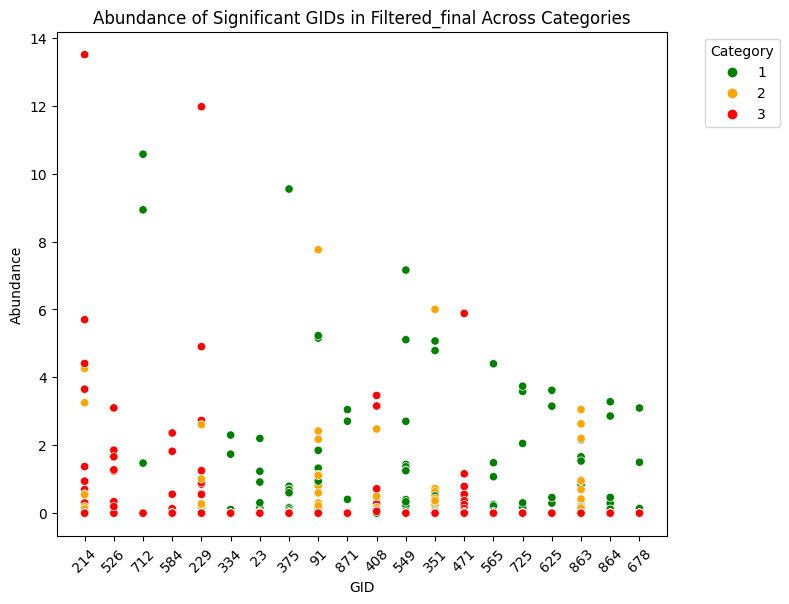

In [20]:
# Melt the dataframe
melted_df = filtered_final.melt(id_vars=['Sites', 'Category'], 
                                value_vars=filtered_final.columns[2:], 
                                var_name='GID', 
                                value_name='Abundance')
# Categories and colors
categories = [1, 2, 3]
colors = ['green', 'orange', 'red']

# Set the figure size
plt.figure(figsize=(8, 6))

# Use seaborn's barplot function for the visualization
sns.scatterplot(x='GID', y='Abundance', hue='Category', data=melted_df, 
            hue_order=categories, palette=colors)

# Set the title and labels
plt.title('Abundance of Significant GIDs in Filtered_final Across Categories')
plt.xlabel('GID')
plt.ylabel('Abundance')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

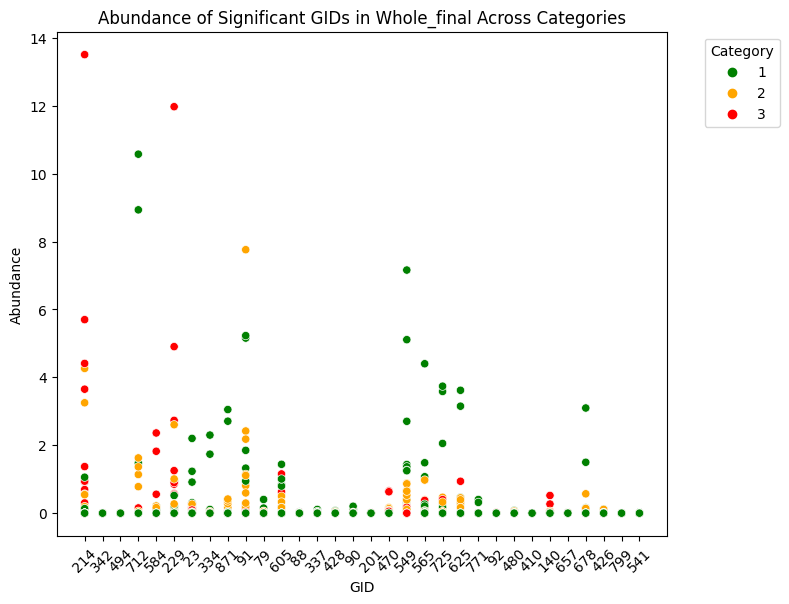

In [21]:
import seaborn as sns
# Melt the dataframe
melted_df = whole_final.melt(id_vars=['Sites', 'Category'], 
                                value_vars=whole_final.columns[2:], 
                                var_name='GID', 
                                value_name='Abundance')
# Categories and colors
categories = [1, 2, 3]
colors = ['green', 'orange', 'red']

# Set the figure size
plt.figure(figsize=(8, 6))

# Use seaborn's barplot function for the visualization
sns.scatterplot(x='GID', y='Abundance', hue='Category', data=melted_df, 
            hue_order=categories, palette=colors)

# Set the title and labels
plt.title('Abundance of Significant GIDs in Whole_final Across Categories')
plt.xlabel('GID')
plt.ylabel('Abundance')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

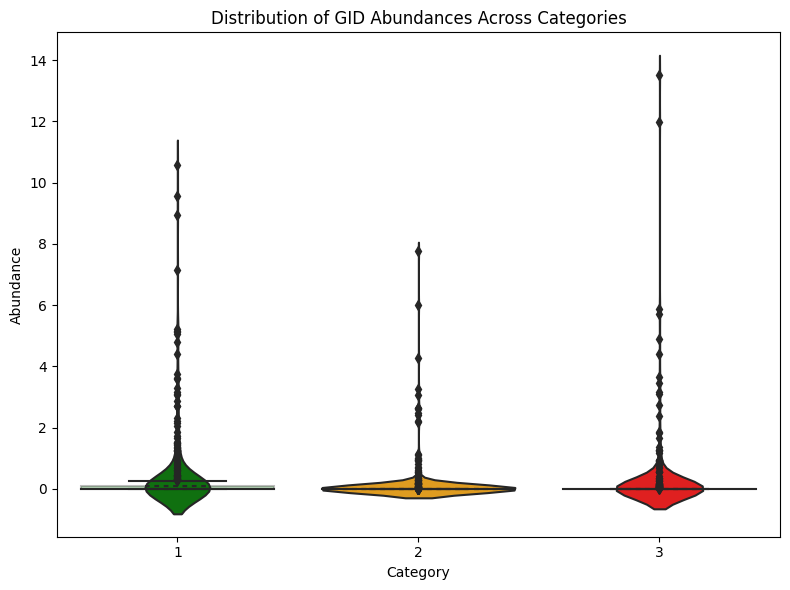

In [22]:
# Melt the dataframe
melted_df = filtered_final.melt(id_vars=['Sites', 'Category'], 
                                value_vars=filtered_final.columns[2:], 
                                var_name='GID', 
                                value_name='Abundance')

# Categories and colors
categories = [1, 2, 3]
colors = ['green', 'orange', 'red']

# Set the figure size
plt.figure(figsize=(8, 6))

# Use seaborn's boxplot function for the visualization
sns.boxplot(x='Category', y='Abundance', data=melted_df, palette=colors, boxprops=dict(alpha=.3))

# Swarmplot
#sns.swarmplot(x='Category', y='Abundance', data=melted_df, color=".25")
# Violin plot
sns.violinplot(x='Category', y='Abundance', data=melted_df, palette=colors, inner="quartile")

# Set the title and labels
plt.title('Distribution of GID Abundances Across Categories')
plt.xlabel('Category')
plt.ylabel('Abundance')

# Display the plot
plt.tight_layout()
plt.show()

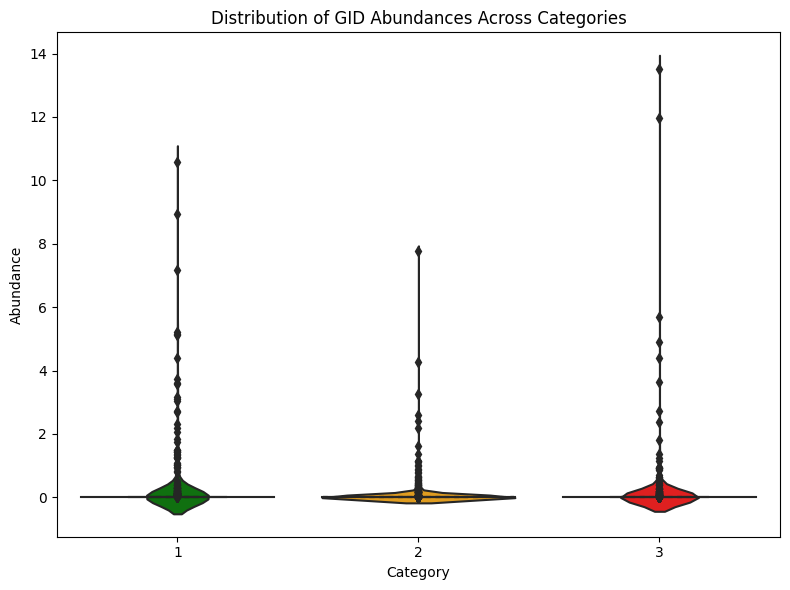

In [23]:
# Melt the dataframe
melted_whole = whole_final.melt(id_vars=['Sites', 'Category'], 
                                value_vars=whole_final.columns[2:], 
                                var_name='GID', 
                                value_name='Abundance')
melted_whole['Abundance'] = pd.to_numeric(melted_whole['Abundance'], errors='coerce')

# Categories and colors
categories = [1, 2, 3]
colors = ['green', 'orange', 'red']

# Set the figure size
plt.figure(figsize=(8, 6))

# Use seaborn's boxplot function for the visualization
sns.boxplot(x='Category', y='Abundance', data=melted_whole, palette=colors, boxprops=dict(alpha=.3))

# Violin plot
sns.violinplot(x='Category', y='Abundance', data=melted_whole, palette=colors, inner="quartile")

# Set the title and labels
plt.title('Distribution of GID Abundances Across Categories')
plt.xlabel('Category')
plt.ylabel('Abundance')

# Display the plot
plt.tight_layout()
plt.show()


In [24]:
whole_final.head()

,Sites,Category,214,342,494,712,584,229,23,334,...,771,92,480,410,140,657,678,426,799,541
1,site_1,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2801,0.0215,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,site_2,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.2332,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,site_3,1,0.0000,0.0000,0.0000,0.0123,0.0000,0.0000,0.3069,0.0000,...,0.0000,0.0000,0.0123,0.0000,0.0000,0.0000,0.0000,0.0246,0.0000,0.0123
4,site_4,1,0.0000,0.0000,0.0022,0.0000,0.0000,0.0000,2.2016,0.0022,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0066,0.0000,0.0220
5,site_5,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0018,0.9148,0.0037,...,0.0000,0.0018,0.0000,0.0018,0.0000,0.0000,0.0074,0.0074,0.0000,0.0000


I am going now to combine the whole_final and filtered_final each with tax values to make the combined taxa_mit_whole and taxa_mit_influencers

In [25]:
pd.options.display.float_format = '{:.4f}'.format
# Read the excel file
Jointax = pd.read_excel('data/Jointax.xlsx', sheet_name='Biotot_jointax', header=[0,1,2,3,4,5,6,7])#, sort=False)#, dtype={i: float for i in range(2, 882)})
Jointax["Sites"]= Jointax["Sites"].astype(str)
Jointax["Category"]= Jointax["Category"].astype(int)
#Drop level of Kindom since it is boring
Jointax.columns = Jointax.columns.droplevel(1)
#Correcting the Tuple-like Index
Jointax.index = Jointax.index.map(lambda x: x[0] if isinstance(x, tuple) else x)

FileNotFoundError: [Errno 2] No such file or directory: 'data/Jointax.xlsx'

In [ ]:
Jointax.head()

,Sites,Category,Clostridiales_Clostridiaceae_02d06,Pirellulales_Pirellulaceae_A17,Lactobacillales_Aerococcaceae_Abiotrophia,Clostridiales_Ruminococcaceae_Acetanaerobacterium,Clostridiales_Ruminococcaceae_Acetivibrio,Clostridiales_Eubacteriaceae_Acetobacterium,Burkholderiales_Alcaligenaceae_Achromobacter,Clostridiales_Acidaminobacteraceae_Acidaminobacter,...,Xanthomonadales_Xanthomonadaceae_Xanthomonas,Burkholderiales_Comamonadaceae_Xenophilus,Xanthomonadales_Xanthomonadaceae_Xylella,Burkholderiales_Unclassified_burkholderiales_Xylophilus,Enterobacteriales_Yersiniaceae_Yersinia,Micrococcales_Microbacteriaceae_Yonghaparkia,Rhodocyclales_Rhodocyclaceae_Z-35,Micrococcales_Microbacteriaceae_Zimmermannella,Rhodocyclales_Rhodocyclaceae_Zoogloea,Sphingomonadales_Sphingomonadaceae_Zymomonas
,Header_2,Phylum,Firmicutes,Planctomycetes,Firmicutes,Firmicutes,Firmicutes,Firmicutes,Proteobacteria,Firmicutes,...,Proteobacteria,Proteobacteria,Proteobacteria,Proteobacteria,Proteobacteria,Actinobacteria,Proteobacteria,Actinobacteria,Proteobacteria,Proteobacteria
,Header_3,Class,Clostridia,Planctomycetia,Bacilli,Clostridia,Clostridia,Clostridia,Betaproteobacteria,Clostridia,...,Gammaproteobacteria,Betaproteobacteria,Gammaproteobacteria,Betaproteobacteria,Gammaproteobacteria,Actinobacteria,Betaproteobacteria,Actinobacteria,Betaproteobacteria,Alphaproteobacteria
,Header_4,Order,Clostridiales,Pirellulales,Lactobacillales,Clostridiales,Clostridiales,Clostridiales,Burkholderiales,Clostridiales,...,Xanthomonadales,Burkholderiales,Xanthomonadales,Burkholderiales,Enterobacteriales,Micrococcales,Rhodocyclales,Micrococcales,Rhodocyclales,Sphingomonadales
,Header_5,Familia,Clostridiaceae,Pirellulaceae,Aerococcaceae,Ruminococcaceae,Ruminococcaceae,Eubacteriaceae,Alcaligenaceae,Acidaminobacteraceae,...,Xanthomonadaceae,Comamonadaceae,Xanthomonadaceae,Unclassified_burkholderiales,Yersiniaceae,Microbacteriaceae,Rhodocyclaceae,Microbacteriaceae,Rhodocyclaceae,Sphingomonadaceae
,Header_6,Genera,02d06,A17,Abiotrophia,Acetanaerobacterium,Acetivibrio,Acetobacterium,Achromobacter,Acidaminobacter,...,Xanthomonas,Xenophilus,Xylella,Xylophilus,Yersinia,Yonghaparkia,Z-35,Zimmermannella,Zoogloea,Zymomonas
,Header_7,GID,1,2,3,4,5,6,7,8,...,873,874,875,876,877,878,879,880,881,882
0,site_1,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.4308,0.5170,0.0000,...,0.0000,0.0000,0.0000,0.0215,0.0000,0.0000,0.0000,0.0000,0.0215,0.0000
1,site_2,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0190,0.3415,0.0000,...,0.0190,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0190,0.0000
2,site_3,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0246,0.3192,0.0000,...,0.0123,0.0000,0.0000,0.0123,0.0000,0.0000,0.0000,0.0000,0.0246,0.0123
3,site_4,1,0.0000,0.0000,0.0154,0.0000,0.0000,0.0176,0.2512,0.0000,...,0.0022,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0066,0.0022


In [ ]:
# Create a set of the GIDs from the 'whole_final' and 'filtered_final' DataFrame
Gids_whole = set(whole_final.columns)
Gids_influencers = set(filtered_final)

Next, we'll filter the columns in Jointax based on this set. Since Jointax has multi-level headers, we'll need to iterate through them to find the columns that match the columns in our set.

In [ ]:
# Initialize an empty list to store the columns to keep
columns_to_keep = []

# Skip the first two columns ('Header_7', 'GID') and iterate through the rest of the columns in 'Jointax'
for col in Jointax.columns[2:]:
    # Because GID or unique identifier is the last element in the multi-level header tuple
    gid = str(col[-1])  # Convert to string just to be sure
    if gid in Gids_whole:
        columns_to_keep.append(col)

# Filter 'Jointax' to only include the columns in 'columns_to_keep'
tax_mit_whole =Jointax.loc[:, columns_to_keep]
# Add back the 'Sites' and 'Category' columns
tax_mit_whole ['Sites'] = Jointax['Sites']
tax_mit_whole ['Category'] = Jointax['Category']

In [ ]:
#organising the columns
cols = [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')] + [col for col in tax_mit_whole.columns if col not in [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')]]
tax_mit_whole = tax_mit_whole.loc[:, cols]

In [ ]:
# Name the levels of the MultiIndex
tax_mit_whole.columns.names = ['Level1', 'Level2', 'Level3', 'Level4', 'Level5', 'Level6', 'Level7']
# Reset Index
tax_mit_whole.reset_index(drop=True, inplace=True)

In [ ]:
# Initialize an empty list to store the columns to keep
columns_to_keep_i = []

# Skip the first two columns ('Header_7', 'GID') and iterate through the rest of the columns in 'Jointax'
for col in Jointax.columns[2:]:
    # Because GID or unique identifier is the last element in the multi-level header tuple
    gid = str(col[-1])  # Convert to string just to be sure
    if gid in Gids_influencers:
        columns_to_keep_i.append(col)

# Filter 'Jointax' to only include the columns in 'columns_to_keep'
tax_mit_influencers =Jointax.loc[:, columns_to_keep_i]

In [ ]:
# Add back the 'Sites' and 'Category' columns
tax_mit_influencers[:, 'Sites'] = Jointax[:, 'Sites'].astype(str)
tax_mit_influencers[:, 'Category'] = Jointax[:, 'Category'].astype(str)

#organising the columns
colsi = [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')] + [col for col in tax_mit_influencers.columns if col not in [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')]]

tax_mit_influencers = tax_mit_influencers.loc[:, colsi]

TypeError: unhashable type: 'slice'

In [ ]:
# Name the levels of the MultiIndex
tax_mit_influencers.columns.names = ['Level1', 'Level2', 'Level3', 'Level4', 'Level5', 'Level6', 'Level7']
tax_mit_influencers.reset_index(drop=True, inplace=True)

tax_mit_influencers.head()

Level1,Sites,Category,Actinomycetales_Actinomycetaceae_Actinomyces,Burkholderiales_Comamonadaceae_Aquabacterium,Clostridiales_Clostridiaceae_Clostridium,Actinomycetales_Corynebacteriaceae_Corynebacterium,Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria,Pasteurellales_Pasteurellaceae_Haemophilus,Rhizobiales_Hyphomicrobiaceae_Hyphomicrobium,Legionellales_Legionellaceae_Legionella,...,Caulobacterales_Caulobacteraceae_Phenylobacterium,Bacteroidales_Porphyromonadaceae_Porphyromonas,Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas,Rhodospirillales_Acetobacteraceae_Roseococcus,Sphingomonadales_Sphingomonadaceae_Sphingosinicella,Burkholderiales_Comamonadaceae_Tepidimonas,Thermales_Thermaceae_Thermus,Burkholderiales_Comamonadaceae_Variovorax,Clostridiales_Veillonellaceae_Veillonella,Rhizobiales_Xanthobacteraceae_Xanthobacter
Level2,,,Actinobacteria,Proteobacteria,Firmicutes,Actinobacteria,Firmicutes,Proteobacteria,Proteobacteria,Proteobacteria,...,Proteobacteria,Bacteroidetes,Proteobacteria,Proteobacteria,Proteobacteria,Proteobacteria,Thermi,Proteobacteria,Firmicutes,Proteobacteria
Level3,,,Actinobacteria,Betaproteobacteria,Clostridia,Actinobacteria,Clostridia,Gammaproteobacteria,Alphaproteobacteria,Gammaproteobacteria,...,Alphaproteobacteria,Bacteroidia,Gammaproteobacteria,Alphaproteobacteria,Alphaproteobacteria,Betaproteobacteria,Deinococci,Betaproteobacteria,Clostridia,Alphaproteobacteria
Level4,,,Actinomycetales,Burkholderiales,Clostridiales,Actinomycetales,Thermoanaerobacterales,Pasteurellales,Rhizobiales,Legionellales,...,Caulobacterales,Bacteroidales,Vibrionales,Rhodospirillales,Sphingomonadales,Burkholderiales,Thermales,Burkholderiales,Clostridiales,Rhizobiales
Level5,,,Actinomycetaceae,Comamonadaceae,Clostridiaceae,Corynebacteriaceae,Thermoanaerobacteraceae,Pasteurellaceae,Hyphomicrobiaceae,Legionellaceae,...,Caulobacteraceae,Porphyromonadaceae,Pseudoalteromonadaceae,Acetobacteraceae,Sphingomonadaceae,Comamonadaceae,Thermaceae,Comamonadaceae,Veillonellaceae,Xanthobacteraceae
Level6,,,Actinomyces,Aquabacterium,Clostridium,Corynebacterium,Gelria,Haemophilus,Hyphomicrobium,Legionella,...,Phenylobacterium,Porphyromonas,Pseudoalteromonas,Roseococcus,Sphingosinicella,Tepidimonas,Thermus,Variovorax,Veillonella,Xanthobacter
Level7,,,23,91,214,229,334,351,375,408,...,549,565,584,625,678,712,725,863,864,871
0,site_1,3,0.2801,0.1939,0.0000,0.0000,0.0215,0.4739,0.5816,0.0000,...,0.2154,0.1723,0.0000,0.0000,0.0000,0.0000,0.4524,1.6588,0.3231,0.0000
1,site_2,1,1.2332,0.1138,0.0000,0.0000,0.0000,0.6261,0.7020,0.0000,...,0.3035,0.2466,0.0000,0.0000,0.0000,0.0000,0.3035,2.1628,3.2821,0.0000
2,site_3,1,0.3069,0.2332,0.0000,0.0000,0.0000,0.4297,0.6875,0.0000,...,0.3069,1.4854,0.0000,0.0000,0.0000,0.0123,3.5846,0.8102,0.2946,0.0000
3,site_4,1,2.2016,0.1410,0.0000,0.0000,0.0022,5.0709,0.6016,0.0044,...,0.2292,4.4009,0.0000,0.0044,0.0000,0.0000,2.0539,1.5360,2.8605,0.0000


In [ ]:
# Save the final DataFrames to a xlsx file
tax_mit_whole.to_excel('data/taxa_mit_whole.xlsx', engine='openpyxl')
tax_mit_influencers.to_excel('data/taxa_mit_influencers.xlsx', engine='openpyxl')

### Uniques and combined 2 and 3
Now I compare the three categories of bacteria genus. So this visualisation only not for the subsequent analysis, we assume that if a genus 
belong to all the categories, we focus on the unique GIDs considering that may be more relevant to see the differences and perhaps more relevant regarding corrosion. If the GID were relevant, why then is not associated with a corrosion traffic light? if were relevant it should have also caused corrosion on the traffic light. So first we identify this common Genus/GIDs intersection so not to put them on the comparison.

In [ ]:
unique_all_1 = pd.read_csv("data/unique_all_1.csv", dtype={i: float for i in range(7, -1)})
unique_all_2 = pd.read_csv("data/unique_all_2.csv", dtype={i: float for i in range(7, -1)})
unique_all_3 = pd.read_csv("data/unique_all_3.csv", dtype={i: float for i in range(7, -1)})

In [ ]:
def preprocess_df(df):
     # Convert 'GID' to string type
    df['GID'] = df['GID'].astype(str)
    # Set the index to 'GID'
    df = df.set_index("GID")
    # Drop the first 7 columns
    unique = df.drop(df.columns[:6], axis=1)
    return unique
 
unique_1_pre = preprocess_df(unique_all_1)
unique_2_pre = preprocess_df(unique_all_2)
unique_3_pre = preprocess_df(unique_all_3)

In [ ]:
def process_dataframe(df):
    # Count the number of times numbers greater than zero appear in each row
    row_counts = df.apply(lambda row: sum(row > 0), axis=1)
    # Create a list containing the indices of the rows where numbers greater than zero are found
    gids = row_counts[row_counts > 0].index.tolist()
    return gids

In [ ]:
gids_1 = process_dataframe(unique_1_pre)
gids_2 = process_dataframe(unique_2_pre)
gids_3 = process_dataframe(unique_3_pre)
# Convert these lists to sets
gids_1_set = set(map(str, gids_1))
gids_2_set = set(map(str, gids_2))
gids_3_set = set(map(str, gids_3))

In [ ]:
# Unique GIDs for each of the sets
unique_gids_1 = gids_1_set.difference(gids_2_set).difference(gids_3_set)
unique_gids_2 = gids_2_set.difference(gids_1_set).difference(gids_3_set)
unique_gids_3 = gids_3_set.difference(gids_2_set).difference(gids_1_set)
common_gids_23= gids_2_set.intersection(gids_3_set)

In [ ]:
def filter_gids_by_count(df, unique_gids_set):
      
    #df_filtered = df[df['GID'].isin(unique_gids_set)]
    df_filtered = df.loc[df.index.isin(unique_gids_set)]
    # Convert all columns to numeric
    #df_filtered = df_filtered.apply(pd.to_numeric, errors='coerce')
    # Count the number of times numbers greater than zero appear in each row
    row_counts = df_filtered.apply(lambda row: sum(row > 0), axis=1)
    # Filter GIDs with counts greater than or equal to 3
    filtered_gids = row_counts[row_counts >= 3].index.tolist()
    return set(map(str, filtered_gids))

# Filter the unique GIDs based on the original DataFrames
filtered_gids_1 = filter_gids_by_count(unique_1_pre, unique_gids_1)
filtered_gids_2 = filter_gids_by_count(unique_2_pre, unique_gids_2)
filtered_gids_3 = filter_gids_by_count(unique_3_pre, unique_gids_3)

# filtered_gids_1, filtered_gids_2, and filtered_gids_3 containing only the GIDs with counts >= 3

In [ ]:
# Selected gids as my gut feeling told me as per only present on 2 and 3 category
selected_gids_23 = 512, 497, 227, 402, 354, 154, 165, 253, 312,336, 384, 581, 606, 695, 705, 727
selected_gids_23 = set(map(str, selected_gids_23))
uniques_gids = filtered_gids_3.union(filtered_gids_1, filtered_gids_2)
unique_plus_23 =  selected_gids_23.union(filtered_gids_1, filtered_gids_2, filtered_gids_2)
# Convert all elements in uniques_gids to strings
uniques_gids = set(map(str, uniques_gids))
unique_plus_23 =set(map(str, unique_plus_23))

Now we taken the original df and take the data from there to have also the taxonomic data
### Unique Columns Dataframe Extraction
Now having the unique genera for each category, we going corroborate that indeed the Gids or Genus are only on one of the categories, we can do it iterating on a df or we can use a plot that indicate if a genus belong to more than one category.

In [ ]:
pd.options.display.float_format = '{:.4f}'.format
# Read the excel file
Jointax = pd.read_excel('data/Jointax.xlsx', sheet_name='Biotot_jointax', header=[0,1,2,3,4,5,6,7])#, sort=False)#, dtype={i: float for i in range(2, 882)})
Jointax["Sites"]= Jointax["Sites"].astype(str)
Jointax["Category"]= Jointax["Category"].astype(int)
#Drop level of Kindom since it is boring
Jointax.columns = Jointax.columns.droplevel(1)
#Correcting the Tuple-like Index
Jointax.index = Jointax.index.map(lambda x: x[0] if isinstance(x, tuple) else x)

In [ ]:
# Initialize an empty list to store the columns to keep from uniques, u mean is only to unique no with plus 2 and 3
columns_to_keep_u = []

# Skip the first two columns ('Sites', 'Category') and iterate through the rest of the columns in 'Jointax'
for col in Jointax.columns[2:]:
    # Because GID or unique identifier is the last element in the multi-level header tuple
    gid = str(col[-1])  # Convert to string just to be sure
    if gid in uniques_gids:
        columns_to_keep_u.append(col)
        
# Filter 'Jointax' to only include the columns in 'columns_to_keep'
tax_unique =Jointax.loc[:, columns_to_keep_u]

In [ ]:
# Add back the 'Sites' and 'Category' columns
tax_unique.loc[:, 'Sites'] = Jointax.loc[:, 'Sites']
tax_unique.loc[:, 'Category'] = Jointax.loc[:, 'Category']
# Reset Index
#tax_unique.reset_index(drop=True, inplace=True)

In [ ]:
#organising the columns
colsu = [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')] + [col for col in tax_unique.columns if col not in [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')]]
tax_unique= tax_unique.loc[:, colsu]
# Name the levels of the MultiIndex
tax_unique.columns.names = ['Level1', 'Level2', 'Level3', 'Level4', 'Level5', 'Level6', 'Level7']
tax_unique.reset_index(drop=True, inplace=True)

I also will consider the uniques joined to the gids contained in both 2 and 3 because those are operational systems with failure on certain degree 2,3.

In [ ]:
# Initialize an empty list to store the columns to keep from uniques
columns_to_keep_23 = []

# Skip the first two columns ('Sites', 'Category') and iterate through the rest of the columns in 'Jointax'
for col in Jointax.columns[2:]:
    # Because GID or unique identifier is the last element in the multi-level header tuple
    gid = str(col[-1])  # Convert to string just to be sure
    if gid in unique_plus_23:
        columns_to_keep_23.append(col)
        
# Filter 'Jointax' to only include the columns in 'columns_to_keep'
tax_unique_plus_23 =Jointax.loc[:, columns_to_keep_23]

In [ ]:
# Restate the sites and categories columns
tax_unique_plus_23.loc[:, 'Sites'] = Jointax.loc[:, 'Sites']
tax_unique_plus_23.loc[:, 'Category'] = Jointax.loc[:, 'Category']

In [ ]:
#organising the columns
cols23 = [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')] + [col for col in tax_unique_plus_23.columns if col not in [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')]]
tax_unique_plus_23= tax_unique_plus_23.loc[:, cols23]

In [ ]:
# Save the final DataFrames to a xlsx file
tax_unique.to_excel('data/tax_unique.xlsx', engine='openpyxl')
tax_unique_plus_23.to_excel('data/tax_unique_plus_23.xlsx', engine='openpyxl')

In [ ]:
#tax_unique_plus_23= tax_unique_plus_23.reset_index()
tax_unique_plus_23.head()

,Sites,Category,Pirellulales_Pirellulaceae_A17,Clostridiales_Lachnospiraceae_Anaerostipes,Desulfovibrionales_Desulfovibrionaceae_Bilophila,Erysipelotrichales_Erysipelotrichaceae_Bulleidia,Clostridiales_Lachnospiraceae_Butyrivibrio,Burkholderiales_Comamonadaceae_Caldimonas,Burkholderiales_Comamonadaceae_Candidatus_symbiobacter,Clostridiales_Lachnospiraceae_Coprococcus,...,Bacteroidales_Porphyromonadaceae_Parabacteroides,Clostridiales_Peptostreptococcaceae_Peptoclostridium,Erysipelotrichales_Erysipelotrichaceae_Psb-m-3,Xanthomonadale_Paracoccaceae_Rhodobacter,Burkholderiales_Comamonadaceae_Roseateles,Nitrosomonadales_Gallionellaceae_Sulfuricella,Rhodocyclales_Rhodocyclaceae_Sulfuritalea,Syntrophobacterales_Syntrophaceae_Syntrophus,Enterobacteriales_Erwiniaceae_Tatumella,Hydrogenophilales_Hydrogenophilaceae_Thiobacillus
,,,Planctomycetes,Firmicutes,Proteobacteria,Firmicutes,Firmicutes,Proteobacteria,Proteobacteria,Firmicutes,...,Bacteroidetes,Firmicutes,Firmicutes,Pseudomonadota,Proteobacteria,Proteobacteria,Proteobacteria,Proteobacteria,Proteobacteria,Proteobacteria
,,,Planctomycetia,Clostridia,Deltaproteobacteria,Erysipelotrichi,Clostridia,Betaproteobacteria,Betaproteobacteria,Clostridia,...,Bacteroidia,Clostridia,Erysipelotrichi,Alphaproteobacteria,Betaproteobacteria,Betaproteobacteria,Betaproteobacteria,Deltaproteobacteria,Gammaproteobacteria,Betaproteobacteria
,,,Pirellulales,Clostridiales,Desulfovibrionales,Erysipelotrichales,Clostridiales,Burkholderiales,Burkholderiales,Clostridiales,...,Bacteroidales,Clostridiales,Erysipelotrichales,Xanthomonadale,Burkholderiales,Nitrosomonadales,Rhodocyclales,Syntrophobacterales,Enterobacteriales,Hydrogenophilales
,,,Pirellulaceae,Lachnospiraceae,Desulfovibrionaceae,Erysipelotrichaceae,Lachnospiraceae,Comamonadaceae,Comamonadaceae,Lachnospiraceae,...,Porphyromonadaceae,Peptostreptococcaceae,Erysipelotrichaceae,Paracoccaceae,Comamonadaceae,Gallionellaceae,Rhodocyclaceae,Syntrophaceae,Erwiniaceae,Hydrogenophilaceae
,,,A17,Anaerostipes,Bilophila,Bulleidia,Butyrivibrio,Caldimonas,Candidatus_symbiobacter,Coprococcus,...,Parabacteroides,Peptoclostridium,Psb-m-3,Rhodobacter,Roseateles,Sulfuricella,Sulfuritalea,Syntrophus,Tatumella,Thiobacillus
,,,2,85,133,154,159,165,190,227,...,524,541,581,606,621,690,695,705,710,727
0,site_1,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,site_2,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,site_3,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0123,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,site_4,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0220,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0022


In [ ]:
# Add back the 'Sites' and 'Category' columns
tax_unique_plus_23.columns = tax_unique_plus_23.columns.droplevel([0,1,2,3,4,5])
tax_unique_plus_23.head()

,,,2,85,133,154,159,165,190,227,...,524,541,581,606,621,690,695,705,710,727
0,site_1,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,site_2,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,site_3,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0123,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,site_4,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0220,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0022
4,site_5,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0018,0.0000,0.0000,0.0000


In [ ]:
#droping the first 2 column 2 
tax_unique_plus_23.drop(tax_unique_plus_23.columns[0:1], axis=1, inplace=True)

In [ ]:
# Restate the sites and categories columns
tax_unique_plus_23.loc[:, 'Sites'] = Jointax.loc[:, 'Sites'].astype(str)
tax_unique_plus_23.loc[:, 'Category'] = Jointax.loc[:, 'Category'].astype(str)

In [ ]:
tax_unique_plus_23.head()

,2,85,133,154,159,165,190,227,238,253,...,581,606,621,690,695,705,710,727,Sites,Category
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,site_1,3
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,site_2,1
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,site_3,1
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0022,site_4,1
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0018,0.0000,0.0000,0.0000,site_5,1


### Plotting to proof separation for unique_plus_23

In [ ]:
tax_unique_plus_23melted_V = tax_unique_plus_23.melt(id_vars= ['Sites','Category'], #['Sites', 'Category'],
                                value_vars=tax_unique_plus_23.columns[2:], 
                                var_name='GID',
                                value_name='Abundance')
uniques_melted_23 = tax_unique_plus_23melted_V[tax_unique_plus_23melted_V['Abundance'] != 0] # avoiding to plot cero data

/home/beatriz/MIC/2_Micro/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:848: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/beatriz/MIC/2_Micro/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:848: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/beatriz/MIC/2_Micro/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:848: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/beatriz/MIC/2_Micro/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:848: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/beatriz/MIC/2_Micro/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:848: UserWarning: The palette list has more values (3) than needed (

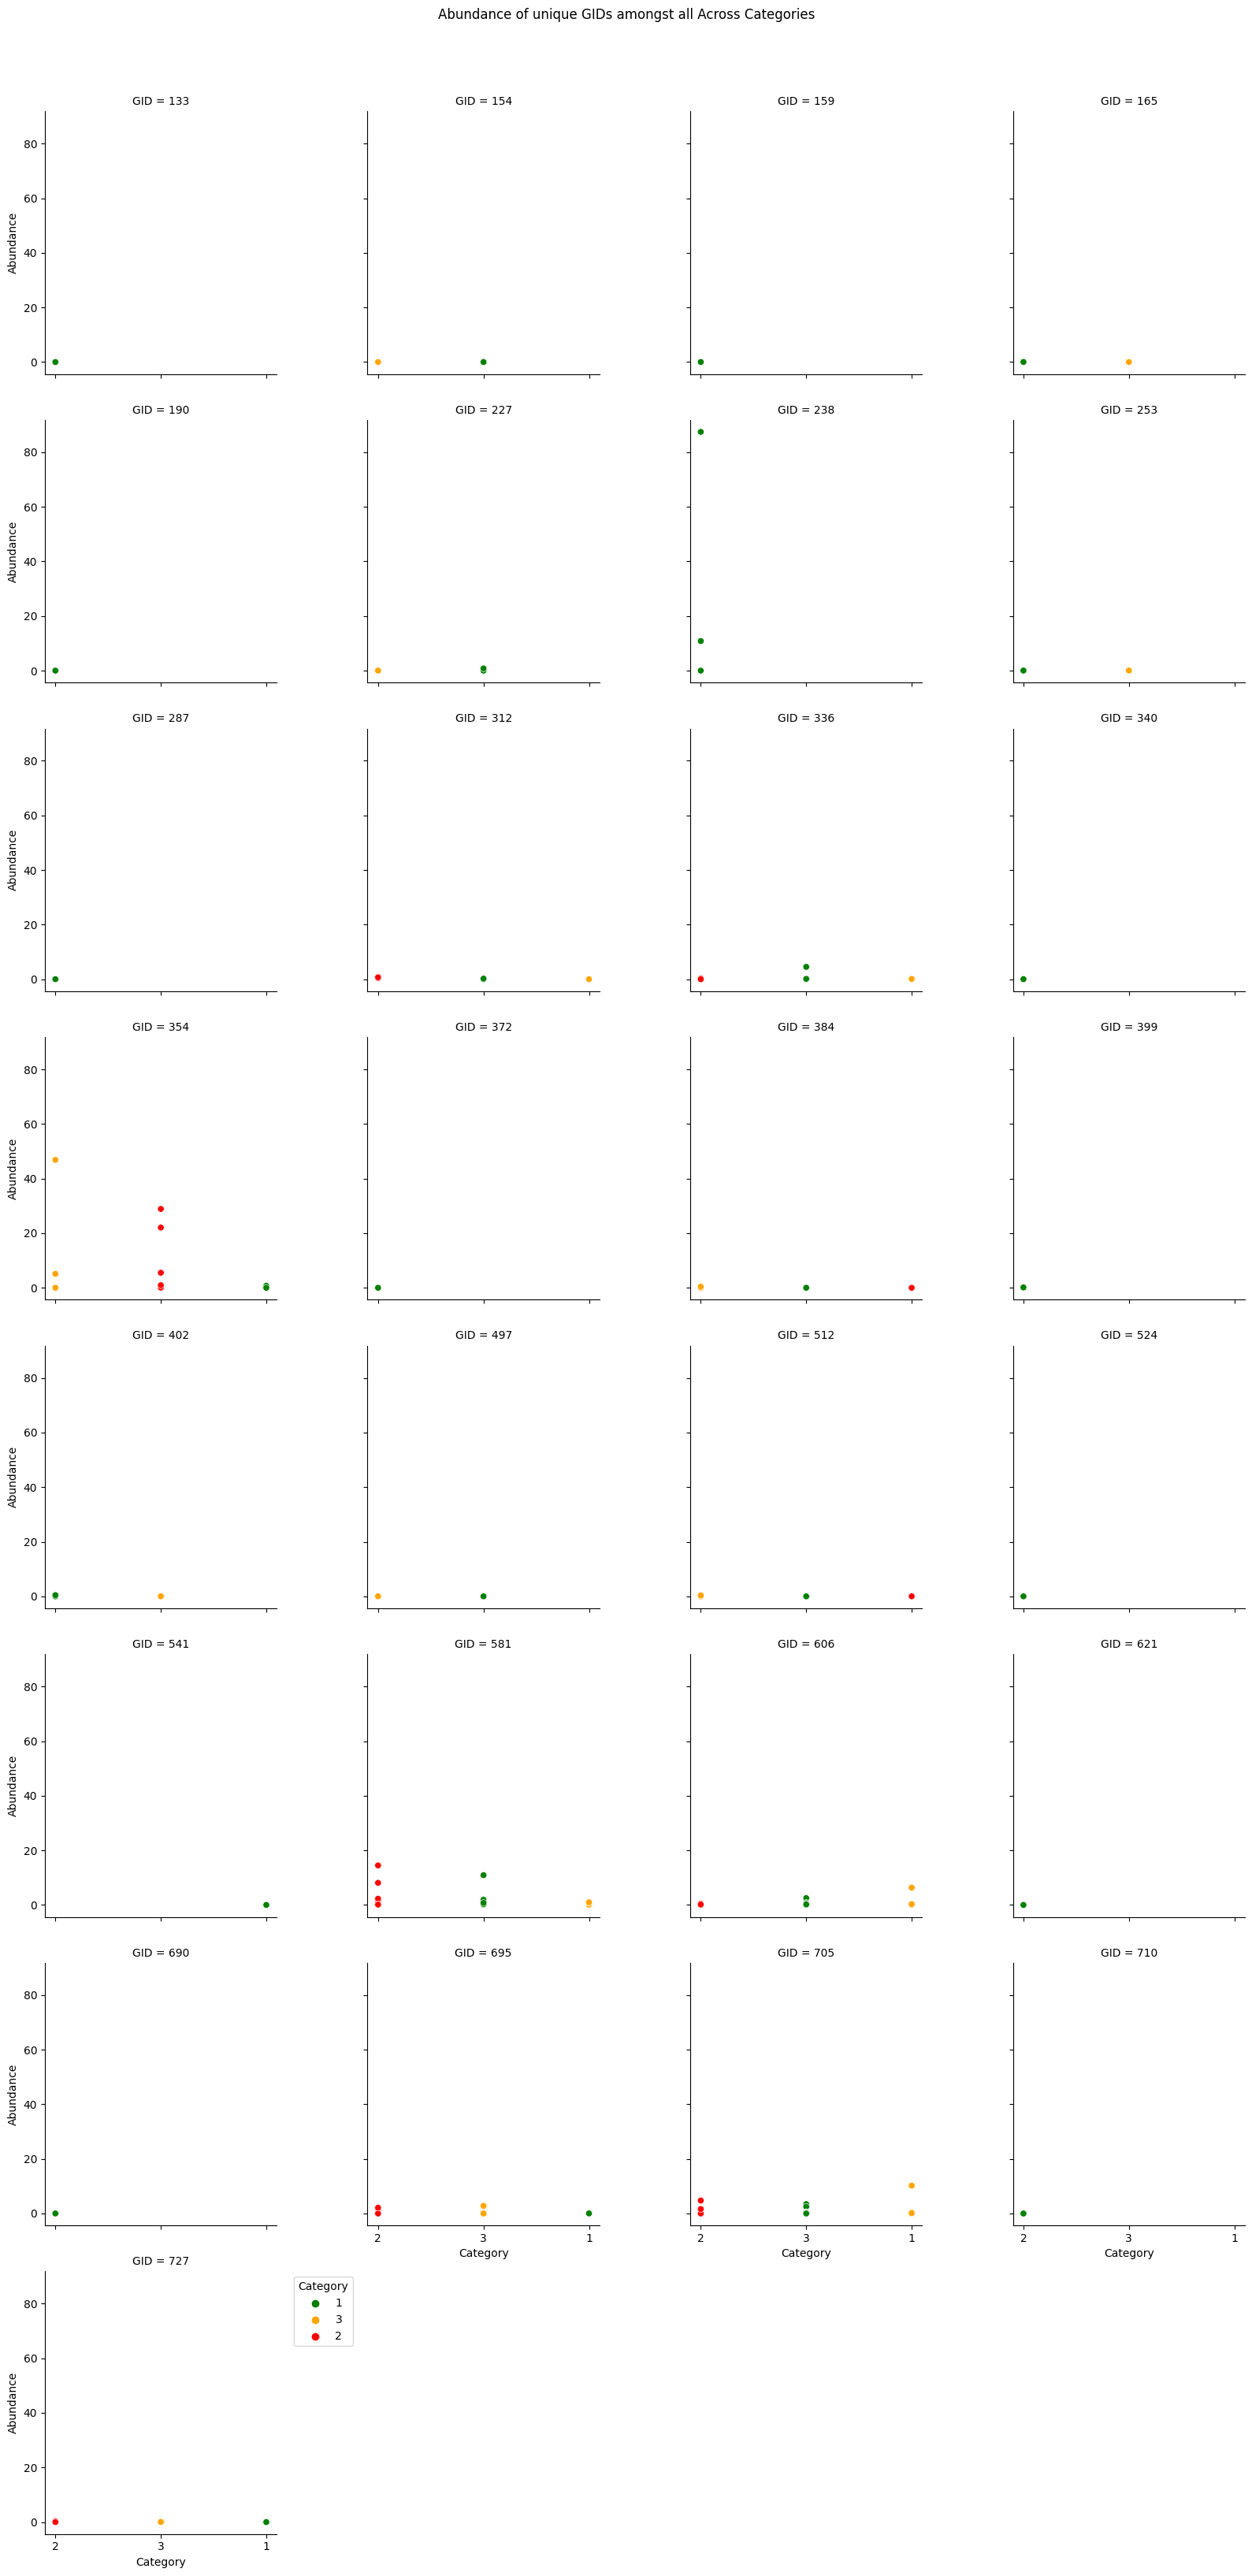

In [ ]:
# Categories and colors
colors = ['green', 'orange', 'red']

# Create facet grid of plots
g = sns.FacetGrid(uniques_melted_23, col="GID", col_wrap=4, sharey=True, height=4)
g.map_dataframe(sns.scatterplot, x="Category", y="Abundance", hue="Category", palette=colors)

# Add x-axis and y-axis labels
g.set_axis_labels("Category", "Abundance")

# Add title
g.fig.suptitle('Abundance of unique GIDs amongst all Across Categories', y=1.02)

# Add legend
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
import json

def count_cells(notebook_path):
    with open(notebook_path, 'r') as f:
        notebook = json.load(f)
        
    code_count = 0
    markdown_count = 0
    for cell in notebook['cells']:
        if cell['cell_type'] == 'code':
            code_count += 1
        elif cell['cell_type'] == 'markdown':
            markdown_count += 1
    
    return code_count, markdown_count

# Usage of the code
notebook_path = '/home/beatriz/MIC/2_Micro/3_PCA_RF_Feature.ipynb'  # Replace with the actual path to your notebook
code_count, markdown_count = count_cells(notebook_path)
print(f'The number of code cells is: {code_count}')
print(f'The number of markdown cells is: {markdown_count}')

The number of code cells is: 47
The number of markdown cells is: 24
